# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [1]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn

## Dataloader

In [30]:
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Download the data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Define the loaders
train_loader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_testset, batch_size=1000)

# Here we can add some data cleanup

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([64, 3, 32, 32])


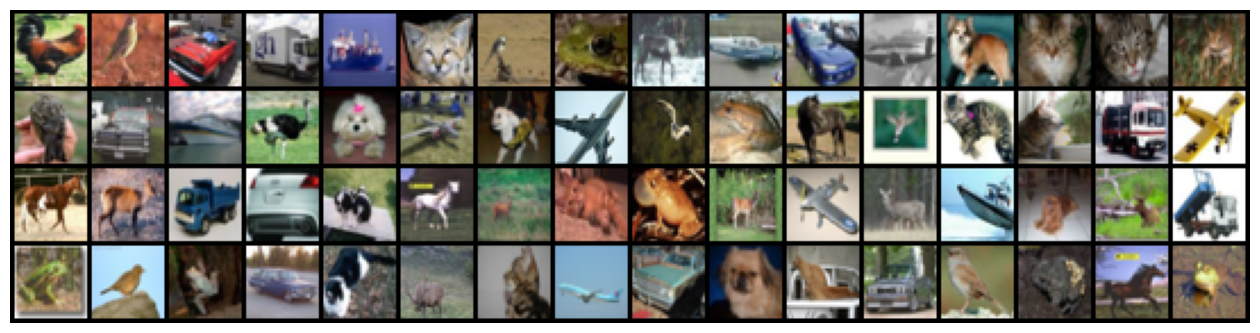

In [37]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

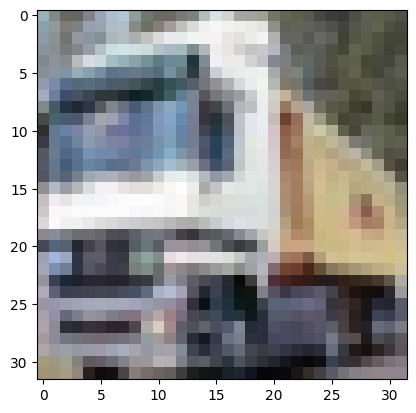

In [184]:
image, label  = cifar_trainset[1] 
plt.imshow(image.view(3,32,32).permute((1, 2, 0)))

## Creating the architecture

In [190]:
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import numpy as np

from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv


class QAE(nn.Module):

    def __init__(self, input_shape = 4, output_shape = 32, kernel_size = 3 , stride = 2, padding = 1):
        self.input_shape = input_shape
        self.ouput_shape = output_shape
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.qnn = QuaternionLinear()
        self.e2 = QuaternionConv()
        
        self.layers = []
        
        self.layers = [
            QuaternionConv(self.input_shape, self.ouput_shape, kernel_size= self.kernel_size, stride=self.stride, padding=self.padding),
            F.relu(),
            QuaternionLinear(8192, 10)
        ]


    def forward(self, x):

        placeholder = None
        for layer in self.layers:
            placeholder = layer(x) 


        out = self.sigmoid(placeholder)
        return out

    def name(self):
        return "QAE"

# Let's try it with a single picture

In [146]:
import os
from   imageio import imread,imwrite
import numpy   as np
import sys

NUM_EPOCHS = 30001
LEARNING_RATE = 0.0005

# This will functino as out "Picture"
train = th.rand((32,32,3))/255

# Copied from the online git
# We are giving it an extra dimension not so sure why
npad  = ((0, 0), (0, 0), (1, 0))
train = np.pad(train, pad_width=npad, mode='constant', constant_values=0)
train = np.transpose(train, (2,0,1))
train = np.reshape(train, (1, train.shape[0], train.shape[1], train.shape[2]))

print(train.shape)


(1, 4, 32, 32)


In [183]:
import torch.nn.functional as F
# Manual

convulution = QuaternionConv(4, 32, kernel_size=3, stride=2, padding=1)
output1 = convulution.forward( torch.from_numpy(train)   )

output2 = F.relu(output1 )

linear = QuaternionLinear(8192 , 1)

output3 = linear.forward(output2.view(1,8192))


## Training the network (still needs to be done)



In [192]:
# Initialize net 
net = QAE(4, 10 )

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 30001

for epoch in range(NUM_EPOCHS):

    output = QAE(train)
    loss   = criterion(output, train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("epoch "+str(epoch+1)+", loss_train "+str(loss.cpu().item()))



TypeError: QuaternionLinear.__init__() missing 2 required positional arguments: 'in_features' and 'out_features'